# Open Data NYC - Property Valuation EDA

In [1]:
from collections import defaultdict
from configparser import ConfigParser
from geopy import geocoders
from matplotlib import pyplot as plt
import folium
import geopandas as gpd
import json
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sys

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

/Users/kmazurczyk/Desktop/AirBnB-Price-Predictor/airbnbenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Data & Clean Up

In [2]:
def get_base_path():
    cwd = os.path.basename(os.getcwd())
    if cwd.lower() != 'airbnb-price-predictor':
        return os.path.dirname(os.getcwd())
    else:
        return os.getcwd()

In [3]:
config = ConfigParser()
config_path = get_base_path() + '/config.ini'
# print("configuring from", config_path)
config.read(config_path)

['/Users/kmazurczyk/Desktop/AirBnB-Price-Predictor/config.ini']

**Load and collate Property Valuation CSVs that were generated from PropertyValuationAPI.py**

**Load a supplementary CSV with building classification codes that will help classify residential properties.**

In [4]:
df = pd.DataFrame()
data_directory = get_base_path() + config['DATA_SOURCES']['data_dir']

# collect valuations_files
valuation_file_names = config['DATA_SOURCES']['valuations_csv']

for root, dirs, files in os.walk(data_directory):
    for file in files:
        if 'ValuationsData' in file:
            temp_df = pd.read_csv(root+file, index_col = 0, low_memory = False)
            df = pd.concat([df, temp_df], ignore_index = True)

    building_file_name = config['DATA_SOURCES']['nyc_building_codes_csv']
    building_codes_df = pd.read_csv(root + building_file_name + '.csv')

df = df.set_index('bldg_class').join(building_codes_df.set_index('BUILDING_CODE'), how='left' ).reset_index()
df.columns = [str.lower(c) for c in df.columns]
df.head()

,bldg_class,parid,boro,block,lot,year,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,yrbuilt,yralt1_range,yralt2_range,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,period,newdrop,noav,aptno,valref,last_modified,classification,description,is_residential
0,D4,1000940001,1,94,1,2025,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,1971,0,0,10,6.0,2163399,R8,367448000,3,0.0,0,NaN,NaN,"Thu, 03 Oct 2024 21:16:10 GMT",ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,1.0
1,D6,1001110100,1,111,100,2025,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,1950,0,0,12,17.0,1264820,R7-2,171964000,3,0.0,0,NaN,NaN,"Thu, 03 Oct 2024 21:16:10 GMT",ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,1.0
2,S4,1001160042,1,116,42,2025,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,1905,0,0,1,5.0,4765,R7-2,1163000,3,0.0,0,NaN,NaN,"Thu, 03 Oct 2024 21:16:10 GMT",PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0
3,C7,1001160046,1,116,46,2025,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,1910,0,0,1,4.0,6924,R7-2,1101000,3,0.0,0,NaN,NaN,"Thu, 03 Oct 2024 21:16:10 GMT",WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,1.0
4,S4,1001160047,1,116,47,2025,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,1905,0,0,1,3.0,2800,R7-2,926000,3,0.0,0,NaN,NaN,"Thu, 03 Oct 2024 21:16:10 GMT",PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0


In [5]:
# filter for residences moved to API call for better sample
# df = df.loc[df['is_residential']==1,:]

### Summary Statistics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900307 entries, 0 to 900306
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bldg_class      900307 non-null  object 
 1   parid           900307 non-null  object 
 2   boro            900307 non-null  int64  
 3   block           900307 non-null  int64  
 4   lot             900307 non-null  int64  
 5   year            900307 non-null  int64  
 6   housenum_lo     883978 non-null  object 
 7   housenum_hi     863136 non-null  object 
 8   units           900307 non-null  int64  
 9   coop_apts       900307 non-null  int64  
 10  street_name     900262 non-null  object 
 11  zip_code        900294 non-null  object 
 12  owner           900293 non-null  object 
 13  land_area       900307 non-null  int64  
 14  yrbuilt         900307 non-null  int64  
 15  yralt1_range    900307 non-null  int64  
 16  yralt2_range    900307 non-null  int64  
 17  num_bldgs 

In [7]:
df.nunique(dropna=False).sort_values()

is_residential         1
last_modified          1
year                   1
period                 1
valref                 2
noav                   2
newdrop                3
boro                   5
classification         7
zoning                40
yralt2_range          44
description           54
bldg_class            54
yralt1_range          88
num_bldgs             95
bld_story            149
zip_code             195
yrbuilt              208
coop_apts            648
units                650
lot                 5560
street_name         8105
aptno              12338
block              13356
land_area          18714
gross_sqft         24349
housenum_hi        31916
housenum_lo        31973
curmkttot          82394
owner             774338
parid             900307
dtype: int64

### Drop 1D Variables

**last_modified, year, period are one dimension so they should be dropped.**

**parid, block, lot are identifiying keys and should be dropped.**

In [8]:
df.drop(['parid','block','lot','last_modified','year','period'], axis=1, inplace=True)
df.head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,yrbuilt,yralt1_range,yralt2_range,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential
0,D4,1,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,1971,0,0,10,6.0,2163399,R8,367448000,0.0,0,NaN,NaN,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,1.0
1,D6,1,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,1950,0,0,12,17.0,1264820,R7-2,171964000,0.0,0,NaN,NaN,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,1.0
2,S4,1,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,1905,0,0,1,5.0,4765,R7-2,1163000,0.0,0,NaN,NaN,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0
3,C7,1,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,1910,0,0,1,4.0,6924,R7-2,1101000,0.0,0,NaN,NaN,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,1.0
4,S4,1,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,1905,0,0,1,3.0,2800,R7-2,926000,0.0,0,NaN,NaN,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0


### Factors & Binary Variables
**valref, noav and newdrop appear to be binary. ensure they are encoded correctly.**

In [9]:
df.loc[:,['valref','noav','newdrop']].apply(lambda x: x.unique())

valref            [nan, Y]
noav                [0, Y]
newdrop    [0.0, 1.0, nan]
dtype: object

**Let's explicitly recast to "Y", "N".**

In [10]:
df[['valref','noav','newdrop']] = df.loc[:,['valref','noav','newdrop']].map(lambda x: 'Y' if x in ('Y',1) else 'N')
df.head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,yrbuilt,yralt1_range,yralt2_range,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential
0,D4,1,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,1971,0,0,10,6.0,2163399,R8,367448000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,1.0
1,D6,1,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,1950,0,0,12,17.0,1264820,R7-2,171964000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,1.0
2,S4,1,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,1905,0,0,1,5.0,4765,R7-2,1163000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0
3,C7,1,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,1910,0,0,1,4.0,6924,R7-2,1101000,N,N,NaN,N,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,1.0
4,S4,1,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,1905,0,0,1,3.0,2800,R7-2,926000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0


**Let's clean up our other class objects and cast as factors for grouping.**

In [11]:
# Boro Code to Name
boroughs = {1:'Manhattan', 2:'Bronx', 3:'Brooklyn', 4:'Queens', 5:'Staten'}
df['boro_name'] = df['boro'].map(boroughs)

In [12]:
# ZIP CODES
# it would be useful to use zip code as a grouping. but a mix of 5 and 9 digit codes increases the cardinality, reduce to 5 digits
df['zip_code'] = df['zip_code'].apply(lambda x: str(x)[:5])
df['zip_code'].nunique()

185

In [13]:
# categoricals
df[['boro','boro_name','valref','noav','newdrop']] = df[['boro','boro_name','valref','noav','newdrop']].astype('category')

# leaving zipcode off as it's very high cardinality
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900307 entries, 0 to 900306
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   bldg_class      900307 non-null  object  
 1   boro            900307 non-null  category
 2   housenum_lo     883978 non-null  object  
 3   housenum_hi     863136 non-null  object  
 4   units           900307 non-null  int64   
 5   coop_apts       900307 non-null  int64   
 6   street_name     900262 non-null  object  
 7   zip_code        900307 non-null  object  
 8   owner           900293 non-null  object  
 9   land_area       900307 non-null  int64   
 10  yrbuilt         900307 non-null  int64   
 11  yralt1_range    900307 non-null  int64   
 12  yralt2_range    900307 non-null  int64   
 13  num_bldgs       900307 non-null  int64   
 14  bld_story       900307 non-null  float64 
 15  gross_sqft      900307 non-null  int64   
 16  zoning          900307 non-null  objec

# COME BACK TO THIS

### Missing Data: Zero & Null
**I noticed many fields with 0.0 when I loaded the data. Let's assess zeroes and null density.**

In [14]:
# ZEROES
df[df == 0].count(axis = 0).sort_values(ascending=False)

yralt2_range      893422
yralt1_range      857287
land_area          81610
yrbuilt            65674
bld_story          57787
num_bldgs          35146
coop_apts          22808
gross_sqft         21775
units              21627
curmkttot           1059
noav                   0
aptno                  0
valref                 0
classification         0
description            0
is_residential         0
newdrop                0
bldg_class             0
zoning                 0
boro                   0
owner                  0
zip_code               0
street_name            0
housenum_hi            0
housenum_lo            0
boro_name              0
dtype: int64

In [15]:
# NULLS
df.isna().sum().sort_values(ascending=False)

aptno             745348
housenum_hi        37171
housenum_lo        16329
street_name           45
owner                 14
bldg_class             0
gross_sqft             0
is_residential         0
description            0
classification         0
valref                 0
noav                   0
newdrop                0
curmkttot              0
zoning                 0
num_bldgs              0
bld_story              0
boro                   0
yralt2_range           0
yralt1_range           0
yrbuilt                0
land_area              0
zip_code               0
coop_apts              0
units                  0
boro_name              0
dtype: int64

##### Year Columns

**We initially wanted to look at yrbuilt, yralt1_range and yralt2_range to see if age of building had a factor in property valuation and AirBNB value. However, due to the high prevalence of missing values stored under "0" and invalid dates that we cannot reconcile, we will drop these columns**f

In [16]:
df.loc[:,['yrbuilt','yralt1_range','yralt2_range']].describe()

,yrbuilt,yralt1_range,yralt2_range
count,900307.000000,900307.000000,900307.000000
mean,1804.490797,96.125789,15.395947
std,507.187441,429.205711,175.385483
min,0.000000,0.000000,0.000000
25%,1920.000000,0.000000,0.000000
50%,1931.000000,0.000000,0.000000
75%,1964.000000,0.000000,0.000000
max,2023.000000,9889.000000,3033.000000


**Below: yralt^_range dates extend into the future, and yrbuilt dates are so early they are not likely accurate.**

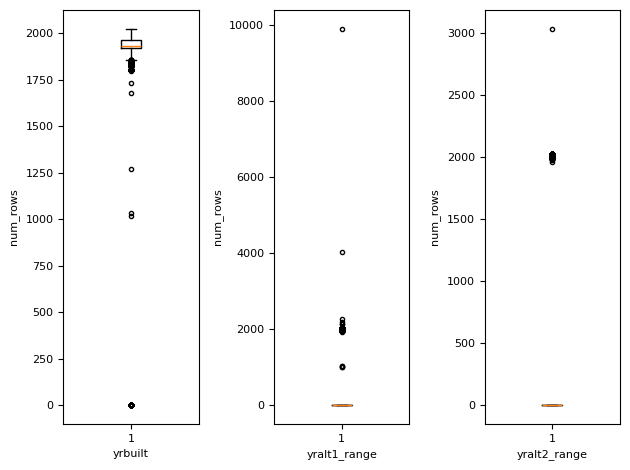

In [17]:
%matplotlib inline

plt.rcParams.update({'axes.labelsize':8, 'ytick.labelsize':8, 'xtick.labelsize':8})

year_columns = ['yrbuilt','yralt1_range','yralt2_range']

fig, axs = plt.subplots(1,3)
for i in range(len(year_columns)):
    axs[i].boxplot(df[year_columns[i]], sym='.')
    axs[i].set_ylabel('num_rows')
    axs[i].set_xlabel(year_columns[i])
plt.tight_layout()

In [18]:
df.drop(year_columns, axis=1, inplace=True)

**Confirm changes**

In [19]:
# ZEROES
df[df == 0].count(axis = 0).sort_values(ascending=False)

land_area         81610
bld_story         57787
num_bldgs         35146
coop_apts         22808
gross_sqft        21775
units             21627
curmkttot          1059
is_residential        0
description           0
classification        0
valref                0
aptno                 0
noav                  0
newdrop               0
bldg_class            0
zoning                0
boro                  0
owner                 0
zip_code              0
street_name           0
housenum_hi           0
housenum_lo           0
boro_name             0
dtype: int64

**Rational for Remaining Zeroes**

* land_area - zero value is actually accurate - most entries are condos and apartments, and their size is reflected under gross_sqft
* coop_apts and units - zero value is accurate for non-unitized properties
* 
In each of these cases NAN would be better than 0 to avoid skewing the distribution.

In [20]:
df.loc[df['land_area']==0,:].sample(3)

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name
164782,R1,3,321,321,1,1,UNION STREET,11231,"LAUD, GEETA",0,1,4.0,1192,R6B,524896,N,N,3B,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN 2-10 UNIT BLDG.,1.0,Brooklyn
277709,R4,3,1065,1065,1,1,VERMONT STREET,11207,"FORD, ANGELA C",0,1,9.0,621,R5,60181,N,N,5 4F,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.,1.0,Brooklyn
242588,R4,3,130,130,1,1,JACKSON STREET,11211,"DENG, POJEN",0,1,4.0,724,R6B,97221,N,N,2A,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.,1.0,Brooklyn


In [21]:
df.loc[df['coop_apts']==0,:].sample(3)

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name
884820,V0,5,NaN,NaN,0,0,HAROLD AVENUE,0.0,PARKS AND RECREATION (GENERAL),6000,0,0.0,0,R3-2,637000,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Staten
872890,V0,5,NaN,NaN,0,0,DRUMGOOLE ROAD EAST,0.0,NYS DOT,267,0,0.0,0,R3-2,12000,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Staten
124917,V0,2,NaN,NaN,0,0,EAST 219 STREET,0,WANDA RANDOLPH,2856,0,0.0,0,R5,237000,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Bronx


In [22]:
df.loc[(df['units']==0) & (df['classification'] != 'VACANT LAND'),:].sample(3)

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name
24989,R4,1,732,732,0,0,WEST END AVENUE,10025,"ZASLAV, KENNETH",3127,1,16.0,1570,R10A,769960,N,N,11,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.,1.0,Manhattan
9083,R4,1,261,261,0,0,WEST 25 STREET,10001,"FANG, JIE",9505,1,12.0,1122,R8A,499831,N,N,4C,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.,1.0,Manhattan
9113,R4,1,261,261,0,0,WEST 25 STREET,10001,"AHL , EAMONN S",9505,1,12.0,1773,R8A,789866,N,N,11B,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.,1.0,Manhattan


In [23]:
# NULLS
df.isna().sum().sort_values(ascending=False)

aptno             745348
housenum_hi        37171
housenum_lo        16329
street_name           45
owner                 14
bldg_class             0
curmkttot              0
is_residential         0
description            0
classification         0
valref                 0
noav                   0
newdrop                0
bld_story              0
zoning                 0
gross_sqft             0
boro                   0
num_bldgs              0
land_area              0
zip_code               0
coop_apts              0
units                  0
boro_name              0
dtype: int64

In [24]:
# nullify zeroes in columns where a zero value wouldn't make sense
cols = ['units','coop_apts','zip_code']
df.replace(0, np.nan, inplace=True)

# confirm null counts went up
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900307 entries, 0 to 900306
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   bldg_class      900307 non-null  object  
 1   boro            900307 non-null  category
 2   housenum_lo     883978 non-null  object  
 3   housenum_hi     863136 non-null  object  
 4   units           878680 non-null  float64 
 5   coop_apts       877499 non-null  float64 
 6   street_name     900262 non-null  object  
 7   zip_code        900307 non-null  object  
 8   owner           900293 non-null  object  
 9   land_area       818697 non-null  float64 
 10  num_bldgs       865161 non-null  float64 
 11  bld_story       842520 non-null  float64 
 12  gross_sqft      878532 non-null  float64 
 13  zoning          900307 non-null  object  
 14  curmkttot       899248 non-null  float64 
 15  newdrop         900307 non-null  category
 16  noav            900307 non-null  categ

In [25]:
df.head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name
0,D4,1,80,80,1652.0,1641.0,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935.0,10.0,6.0,2163399.0,R8,367448000.0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,1.0,Manhattan
1,D6,1,20,70,1947.0,1934.0,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000.0,12.0,17.0,1264820.0,R7-2,171964000.0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,1.0,Manhattan
2,S4,1,25,25,5.0,4.0,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024.0,1.0,5.0,4765.0,R7-2,1163000.0,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0,Manhattan
3,C7,1,35,35,12.0,10.0,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000.0,1.0,4.0,6924.0,R7-2,1101000.0,N,N,NaN,N,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,1.0,Manhattan
4,S4,1,37,37,5.0,4.0,MADISON STREET,10038,THREE BROTHERS REALTY,900.0,1.0,3.0,2800.0,R7-2,926000.0,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,1.0,Manhattan


### Drop Rows/Columns

**Rows**
* Drop where is_residential is false/blank
* Check valuations and decide what to do with properties that are double-counted with another lot 'valref' 
* Check valuations and decide what to do with new lots 'newdrop' 
* Check valuations and decide what to do with valuation for buildings 'in progress' ie possibly under construction - column 'noav'
* Drop rows with null/zero market values, since this is the main measure

**Columns: Year Built and Year Altered Columns**
* We wanted to look at age of building and renovations against property value. However, columns representing year built and year(s) renovated have a high number of invalid dates. See the distributions below - values >2024 are impossible, and values <1700 are unlikely. 
* These values were confirmed at source. So we will remove these columns.

**Columns: IDs and Reference Columns**
* Drop identifying columns parid, boro, block, lot and reference columns owner, noav, valref, last_modified, new_drop, period, is_residential

In [26]:
# valref - decide what to do wtih properties that are double counted with another listing
df.loc[df['valref']=='Y'].head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name
624,V1,1,NaN,NaN,NaN,NaN,GRAND STREET,10002,CLINTON BROOME DEVELOPMENT LLC,NaN,NaN,NaN,NaN,R8,NaN,N,N,NaN,Y,VACANT LAND,ZONED COMMERCIAL OR MANHATTAN RESIDENTIAL,1.0,Manhattan
625,V1,1,410,410,NaN,NaN,GRAND STREET,10002,UNAVAILABLE OWNER,56032.0,NaN,NaN,NaN,R8,NaN,N,N,NaN,Y,VACANT LAND,ZONED COMMERCIAL OR MANHATTAN RESIDENTIAL,1.0,Manhattan
626,V1,1,NaN,NaN,NaN,NaN,BROOME STREET,10002,CLINTON BROOME DEVELOPMENT LLC,75737.0,NaN,NaN,NaN,R8,NaN,N,N,NaN,Y,VACANT LAND,ZONED COMMERCIAL OR MANHATTAN RESIDENTIAL,1.0,Manhattan
7222,V1,1,NaN,NaN,NaN,NaN,GREENWICH STREET,0,"HINSCH, JONATHAN ADAM PARK",3402.0,NaN,NaN,NaN,R6,NaN,N,N,NaN,Y,VACANT LAND,ZONED COMMERCIAL OR MANHATTAN RESIDENTIAL,1.0,Manhattan
7230,V1,1,NaN,NaN,NaN,NaN,WEST 10 STREET,0,UNAVAILABLE OWNER,NaN,NaN,NaN,NaN,R6,NaN,N,N,NaN,Y,VACANT LAND,ZONED COMMERCIAL OR MANHATTAN RESIDENTIAL,1.0,Manhattan


In [27]:
# most of these valref properties appear to have a lot of nulls. let's check to see if many have a market value
print('null market value rows',df.loc[df['valref']=='Y','curmkttot'].isna().sum())
print('valued market value rows',df.loc[df['valref']=='Y','curmkttot'].notna().sum())
print('out of',df.loc[df['valref']=='Y',:].count())

null market value rows 492
valued market value rows 23
out of bldg_class        515
boro              515
housenum_lo        50
housenum_hi        48
units               6
coop_apts           6
street_name       491
zip_code          515
owner             515
land_area         466
num_bldgs           7
bld_story           6
gross_sqft          6
zoning            515
curmkttot          23
newdrop           515
noav              515
aptno               1
valref            515
classification    515
description       515
is_residential    515
boro_name         515
dtype: int64


In [28]:
# majority of valref listings do not have a curmktot - so let's eliminate these rows to avoid duplicates
df = df.loc[df['valref'] != 'Y']

In [29]:
# new drop indicates new properties
df.loc[df['newdrop']==1].head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name


In [30]:
# noav - construction?

In [31]:
# drop columns

In [32]:
# scale valuations
# where coop apt > 1 or units > 1, unitize the value

### Feature Engineering
* We have a mixture of properties - individual apartments and homes, multidwelling residences. We need to accurately flag unitized properties, scale their continuous features, and identify variables that can be a good common denominator across building types

In [33]:
# Zoning Code to Category

def extract_zone(zone):
    return str.split(zone,'-')[0][1:]

def categorize_density(zone):
    if int(zone) <= 5:
        return 'low_density'
    elif int(zone) > 5:
        return 'high_density'
    else:
        return Null

df['density'] = df['zoning'].map(lambda x: extract_zone(x))
df['density'].unique()

array(['8', '7', '7A', '8A', '9', '8B', '7B', '8X', '6', '10', '6A', '9X',
       '9A', '10H', '10A', '7D', '7X', '5', '1', '4A', '6B', '5B', '5A',
       '5D', '3A', '3', '3X', '4', '2', '4B', '2X', '2A', '12A'],
      dtype=object)

## Check Distributions

* mean, median market value by borough, zipcode, zoning type, residential type
* have we sampled evenly geographically or need to go back and get more data?

In [34]:
# load geo visualizations
# https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-/pri4-ifjk/data

# EDA

### Geographic Distribution

In [35]:
df.nunique()

bldg_class            54
boro                   5
housenum_lo        31968
housenum_hi        31911
units                649
coop_apts            647
street_name         8096
zip_code             185
owner             774117
land_area          18626
num_bldgs             94
bld_story            148
gross_sqft         24347
zoning                40
curmkttot          82392
newdrop                2
noav                   2
aptno              12337
valref                 1
classification         7
description           54
is_residential         1
boro_name              5
density               33
dtype: int64

### Boro & Building Type

**Let's look at the distribution of different types of residences (classification) by borough (boro_name).**

In [36]:
market_values = df[['boro_name','classification','curmkttot','units']]

In [37]:
market_values.head()

,boro_name,classification,curmkttot,units
0,Manhattan,ELEVATOR APARTMENTS,367448000.0,1652.0
1,Manhattan,ELEVATOR APARTMENTS,171964000.0,1947.0
2,Manhattan,PRIMARILY RES. - MIXED USE,1163000.0,5.0
3,Manhattan,WALK UP APARTMENTS,1101000.0,12.0
4,Manhattan,PRIMARILY RES. - MIXED USE,926000.0,5.0


In [38]:
df.groupby('boro_name').size()

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_45485/257996624.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('boro_name').size()


boro_name
Bronx         92894
Brooklyn     289654
Manhattan     62654
Queens       329614
Staten       124976
dtype: int64

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_45485/1159420167.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels=axs[0].get_xticklabels(),rotation=45)
/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_45485/1159420167.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels=axs[1].get_xticklabels(),rotation=45)


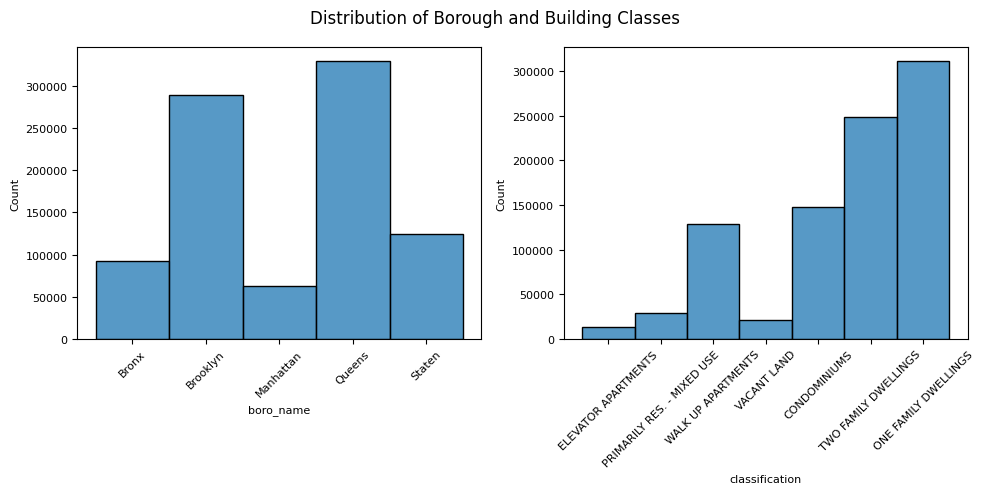

In [39]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.suptitle('Distribution of Borough and Building Classes')

sns.histplot(market_values, x='boro_name', ax=axs[0])
axs[0].set_xticklabels(labels=axs[0].get_xticklabels(),rotation=45)

sns.histplot(market_values, x='classification', ax=axs[1])
axs[1].set_xticklabels(labels=axs[1].get_xticklabels(),rotation=45)

plt.tight_layout()

In [40]:
market_values['curmkttot'].size

899792

In [41]:
x = [i for i in range(market_values['curmkttot'].size)]

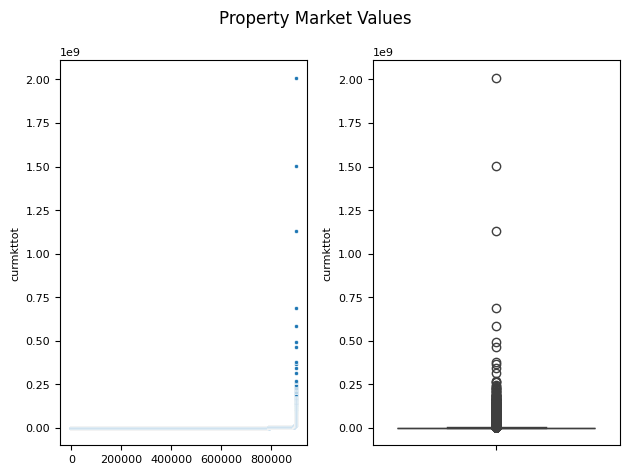

In [42]:
fig,axs = plt.subplots(1,2)

sns.scatterplot(y=market_values['curmkttot'].sort_values(),x=x,marker='.',ax=axs[0])
sns.boxplot(market_values['curmkttot'],ax=axs[1])

fig.suptitle('Property Market Values')

plt.tight_layout()


In [43]:
# counts, bins = np.histogram(market_values['curmkttot'])
# for c, b in counts, bins:
#     print(c)
#     print(b)
# # plt.stairs(counts,bins,color='purple')
# plt.title('Property Market Values')

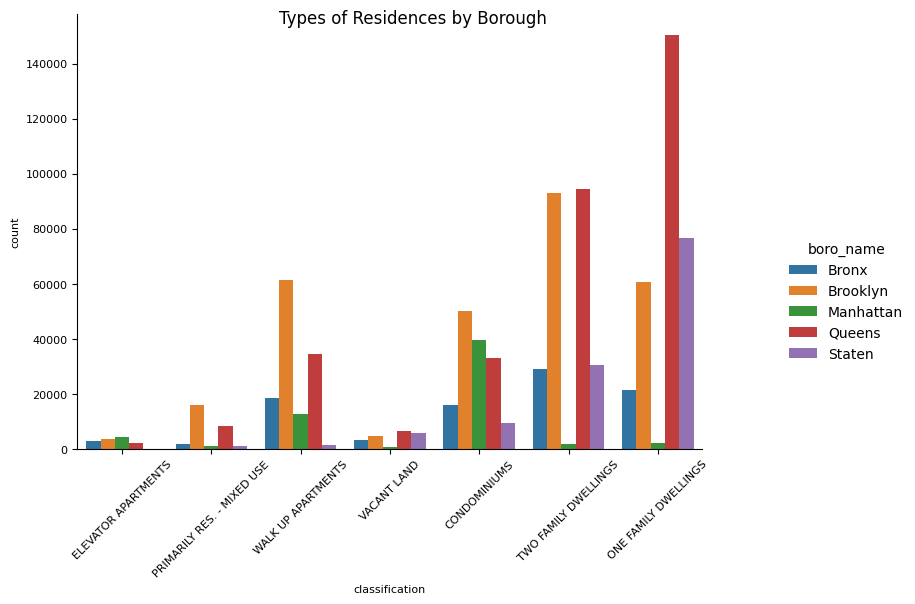

In [46]:
g = sns.catplot(market_values, x='classification', hue='boro_name', kind='count')
g.figure.set_size_inches(10,5)
g.figure.suptitle('Types of Residences by Borough')
g.set_xticklabels(labels=market_values['classification'].unique(), rotation = 45)

In [ ]:
# sns.catplot(market_values, x='classification', hue='boro_name', y='curmkttot', kind='swarm')

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_45485/4084411937.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  market_values_pivot = market_values.pivot_table(index='classification',columns='boro_name',values='curmkttot')
/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_45485/4084411937.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  units_pivot = market_values.pivot_table(index='classification',columns='boro_name',values='units')


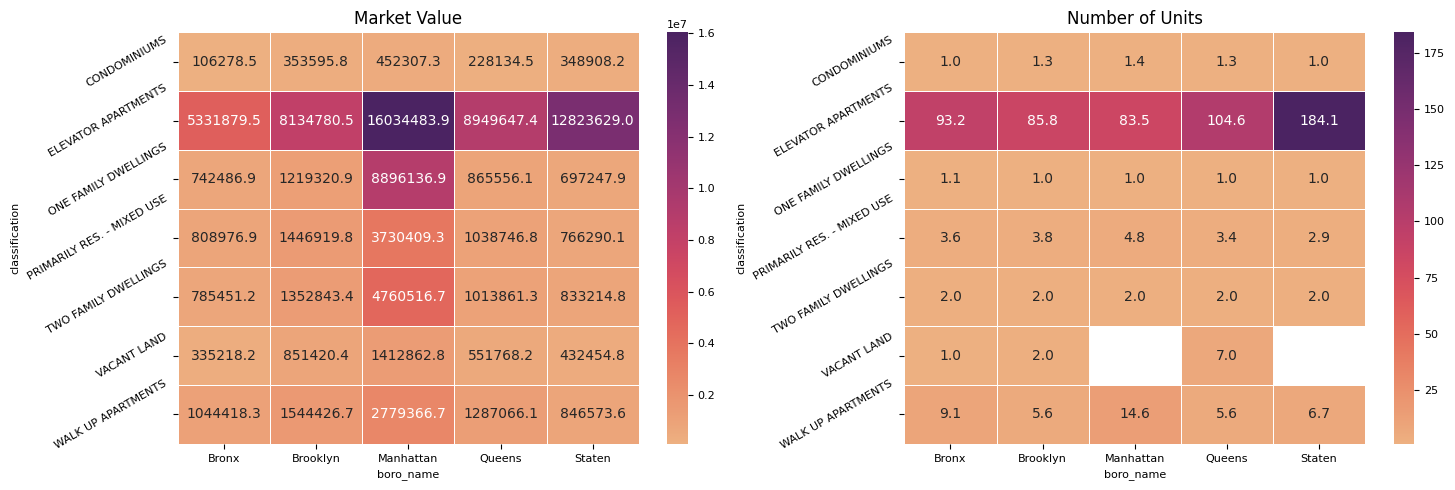

In [47]:
market_values_pivot = market_values.pivot_table(index='classification',columns='boro_name',values='curmkttot')
units_pivot = market_values.pivot_table(index='classification',columns='boro_name',values='units')

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,5)

sns.heatmap(market_values_pivot, ax=axs[0], annot=True, fmt='.1f', linewidth=.5, cmap=sns.color_palette('flare',as_cmap=True))
axs[0].set_title('Market Value')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=30)

sns.heatmap(units_pivot, ax=axs[1], annot=True, fmt='.1f', linewidth=.5, cmap=sns.color_palette('flare',as_cmap=True))
axs[1].set_title('Number of Units')
axs[1].set_yticklabels(axs[1].get_yticklabels(), rotation=30)

plt.tight_layout()



In [51]:
df.sort_values('curmkttot').head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name,density
726703,V0,4,NaN,NaN,NaN,NaN,LAKEVIEW BLVD EAST,0,DCAS,1.0,NaN,NaN,NaN,R3A,10.0,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Queens,3A
128132,V0,2,NaN,NaN,NaN,NaN,BRUNER AVENUE,10469,BEECHWOOD BRUNER BUILDING CORP,4046.0,NaN,NaN,NaN,R5,16.0,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Bronx,5
571247,R4,4,43-18,43-18,1.0,1.0,MAIN STREET,11355,UNAVAILABLE OWNER,NaN,1.0,14.0,621.0,R6,19.0,N,N,1&M-G,N,CONDOMINIUMS,CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.,1.0,Queens,6
384724,V0,3,NaN,NaN,NaN,NaN,DUNNE COURT,11235,UNAVAILABLE OWNER,1.0,NaN,NaN,NaN,R4,130.0,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Brooklyn,4
840932,V0,5,NaN,NaN,NaN,NaN,MALLORY AVENUE,0.0,UNAVAILABLE OWNER,7146.0,NaN,NaN,NaN,R3X,161.0,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Staten,3X


In [56]:
market_values.groupby(['boro_name','classification']).sum('curmkttot') #sort_values('curmkttot',ascending=False).head()

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_45485/1173563967.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  market_values.groupby(['boro_name','classification']).sum('curmkttot') #sort_values('curmkttot',ascending=False).head()


curmkttot     units
boro_name classification                                    
Bronx     CONDOMINIUMS                1.714697e+09   16907.0
          ELEVATOR APARTMENTS         1.557975e+10  273867.0
          ONE FAMILY DWELLINGS        1.582759e+10   22414.0
          PRIMARILY RES. - MIXED USE  1.372834e+09    6159.0
          TWO FAMILY DWELLINGS        2.288726e+10   58288.0
          VACANT LAND                 1.059960e+09       1.0
          WALK UP APARTMENTS          1.928101e+10  167346.0
Brooklyn  CONDOMINIUMS                1.769535e+10   64043.0
          ELEVATOR APARTMENTS         2.896795e+10  311097.0
          ONE FAMILY DWELLINGS        7.416519e+10   60834.0
          PRIMARILY RES. - MIXED USE  2.328383e+10   60558.0
          TWO FAMILY DWELLINGS        1.256764e+11  185830.0
          VACANT LAND                 4.059573e+09       4.0
          WALK UP APARTMENTS          9.450656e+10  340677.0
Manhattan CONDOMINIUMS                1.795750e+10   54477.0
          ELEVATOR APARTMENTS         6.941328e+10  363320.0
          ONE FAMILY DWELLINGS        1.854845e+10    2085.0
          PRIMARILY RES. - MIXED USE  4.745081e+09    6111.0
          TWO FAMILY DWELLINGS        8.321383e+09    3502.0
          VACANT LAND                 8.392405e+08       0.0
          WALK UP APARTMENTS          3.579268e+10  187709.0
Queens    CONDOMINIUMS                7.505624e+09   43774.0
          ELEVATOR APARTMENTS         1.858842e+10  221239.0
          ONE FAMILY DWELLINGS        1.301346e+11  153224.0
          PRIMARILY RES. - MIXED USE  8.879208e+09   29049.0
          TWO FAMILY DWELLINGS        9.584233e+10  189070.0
          VACANT LAND                 3.579872e+09       7.0
          WALK UP APARTMENTS          4.448358e+10  193489.0
Staten    CONDOMINIUMS                3.239961e+09    9298.0
          ELEVATOR APARTMENTS         7.950650e+08   11599.0
          ONE FAMILY DWELLINGS        5.334574e+10   76510.0
          PRIMARILY RES. - MIXED USE  8.206967e+08    3073.0
          TWO FAMILY DWELLINGS        2.545138e+10   61092.0
          VACANT LAND                 2.524671e+09       0.0
          WALK UP APARTMENTS          1.386688e+09   11026.0

In [50]:
df.sort_values('curmkttot',ascending=False).head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,is_residential,boro_name,density
435215,V3,3,NaN,NaN,NaN,NaN,FLATBUSH AVENUE,0,NYC DSBS,23108842.0,NaN,NaN,NaN,R4-1,2.010493e+09,N,N,NaN,N,VACANT LAND,ZONED PRIMARILY RESIDENTIAL; NOT MANHATTAN,1.0,Brooklyn,4
13170,D7,1,240,240,8812.0,8764.0,1 AVENUE,10009,BPP ST OWNER LLC,2675000.0,35.0,13.0,8942176.0,R7-2,1.502480e+09,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,1.0,Manhattan,7
28864,D4,1,NaN,NaN,8088.0,8018.0,MAIN STREET,10044,"RIVERWALK 8 AFFORDABLE, L.P.",4227757.0,39.0,18.0,4786701.0,R7-2,1.131457e+09,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,1.0,Manhattan,7
757783,V0,4,NaN,NaN,NaN,NaN,CROSS BAY BOULEVARD,11414,UNITED STATES OF AMERICA,11600000.0,NaN,NaN,NaN,R3A,6.881870e+08,N,N,NaN,N,VACANT LAND,ZONED RESIDENTIAL; NOT MANHATTAN,1.0,Queens,3A
139694,D4,2,2049,2049,10948.0,10914.0,BARTOW AVENUE,10475,RIVERBAY CORPORATION,5048550.0,32.0,33.0,13540113.0,R6,5.822660e+08,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,1.0,Bronx,6
